In [1]:
!pip install pystac-client planetary-computer rioxarray shapely dask[distributed] rasterio xarray s3fs

In [2]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask
from dask.distributed import Client, LocalCluster
import xarray as xr
import rioxarray
import rasterio
from rasterio import windows, warp
from shapely.geometry import box, shape
import pystac_client
import planetary_computer
from planetary_computer import sign

In [3]:
#bounding box over Bucegi Mountains
min_lon, min_lat = 25.35, 45.35
max_lon, max_lat = 25.60, 45.60

bucegi_polygon = box(min_lon, min_lat, max_lon, max_lat)
bucegi_aoi = bucegi_polygon.__geo_interface__

time_range = "2024-06-01/2024-09-30"  # summer 2024
print("AOI bounds (lon/lat):", bucegi_polygon.bounds)

AOI bounds (lon/lat): (25.35, 45.35, 25.6, 45.6)


In [4]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=bucegi_aoi,
    datetime=time_range,
    query={"eo:cloud_cover": {"lt": 20}},  # fairly clear
)

items = list(search.get_items())
print("Found", len(items), "Sentinel-2 L2A items in AOI/time range")

if not items:
    raise ValueError("No Sentinel-2 items found. Change AOI/time_range.")
    
#limit to a few scenes so it fits in memory
max_scenes = min(4, len(items))
items = items[:max_scenes]
print("Using", len(items), "scenes for this project.")

/opt/conda/lib/python3.11/site-packages/pystac_client/item_search.py:925: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


Found 15 Sentinel-2 L2A items in AOI/time range
Using 4 scenes for this project.


In [5]:
os.makedirs("s2_downloads", exist_ok=True)

def download_band_clipped(item, asset_name, aoi_geojson, out_dir="s2_downloads"):
    """
    - item: STAC item
    - asset_name: "B04" for red, "B08" for NIR
    - aoi_geojson: AOI in EPSG:4326
    Saves a clipped GeoTIFF and returns its path.
    """
    href = item.assets[asset_name].href
    url = sign(href)

    geom = shape(aoi_geojson)
    aoi_bounds_latlon = geom.bounds #(minx, miny, maxx, maxy) in lon/lat

    out_path = os.path.join(out_dir, f"{item.id}_{asset_name}_clipped.tif")

    with rasterio.open(url) as src:
        #reproject AOI bounds to the raster CRS
        aoi_bounds_proj = warp.transform_bounds(
            "EPSG:4326", src.crs, *aoi_bounds_latlon
        )

        #window covering AOI
        win = windows.from_bounds(*aoi_bounds_proj, transform=src.transform)

        data = src.read(1, window=win)
        transform = windows.transform(win, src.transform)

        profile = src.profile
        profile.update(
            {
                "height": data.shape[0],
                "width": data.shape[1],
                "transform": transform,
            }
        )

        with rasterio.open(out_path, "w", **profile) as dst:
            dst.write(data, 1)

    return out_path

In [6]:
red_paths = []
nir_paths = []
times = []

for i, item in enumerate(items):
    print(f"\nDownloading scene {i+1}/{len(items)}: {item.id}")
    t_start = time.time()
    
    red_path = download_band_clipped(item, "B04", bucegi_aoi)
    nir_path = download_band_clipped(item, "B08", bucegi_aoi)
    
    red_paths.append(red_path)
    nir_paths.append(nir_path)
    
    item_time = item.properties.get("datetime", None) or item.datetime
    times.append(pd.to_datetime(item_time))
    
    print("  Saved:", red_path)
    print("  Saved:", nir_path)
    print(f"  Done in {time.time() - t_start:.1f} s")

print("\nAll bands downloaded.")


  Saved: s2_downloads/S2B_MSIL2A_20240924T092029_R093_T35TLL_20240924T120844_B04_clipped.tif
  Saved: s2_downloads/S2B_MSIL2A_20240924T092029_R093_T35TLL_20240924T120844_B08_clipped.tif
  Done in 11.1 s

  Saved: s2_downloads/S2B_MSIL2A_20240921T090559_R050_T35TLL_20240921T115053_B04_clipped.tif
  Saved: s2_downloads/S2B_MSIL2A_20240921T090559_R050_T35TLL_20240921T115053_B08_clipped.tif
  Done in 11.7 s

  Saved: s2_downloads/S2B_MSIL2A_20240815T091559_R093_T35TLL_20240815T120839_B04_clipped.tif
  Saved: s2_downloads/S2B_MSIL2A_20240815T091559_R093_T35TLL_20240815T120839_B08_clipped.tif
  Done in 8.6 s

  Saved: s2_downloads/S2B_MSIL2A_20240812T090559_R050_T35TLL_20240812T121111_B04_clipped.tif
  Saved: s2_downloads/S2B_MSIL2A_20240812T090559_R050_T35TLL_20240812T121111_B08_clipped.tif
  Done in 10.8 s

All bands downloaded.


In [8]:
#Dask cluster
cluster = LocalCluster(
    n_workers=2,
    threads_per_worker=1,
    processes=True,
    memory_limit="1.0GB",
)
client = Client(cluster)
client

<Client: 'tcp://127.0.0.1:39563' processes=2 threads=2, memory=1.86 GiB>

2025-12-10 20:08:42,049 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:38397 (pid=14008) exceeded 95% memory budget. Restarting...
2025-12-10 20:08:42,119 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:38397' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('getitem-b9538de58d5edd22266bbad092e910da', 1, 4, 1), ('getitem-b9538de58d5edd22266bbad092e910da', 1, 5, 0), ('getitem-b9538de58d5edd22266bbad092e910da', 0, 0, 0), ('getitem-b9538de58d5edd22266bbad092e910da', 1, 5, 3), ('getitem-b9538de58d5edd22266bbad092e910da', 0, 3, 2), ('getitem-b9538de58d5edd22266bbad092e910da', 0, 0, 3), ('getitem-b9538de58d5edd22266bbad092e910da', 0, 1, 2), ('getitem-b9538de58d5edd22266bbad092e910da', 0, 5, 2), ('getitem-b9538de58d5edd22266bbad092e910da', 1, 1, 2), ('getitem-b9538de58d5edd22266bbad092e910da', 1, 3, 2), ('getitem-b9538de58d5edd22266bbad092e910da', 0, 2, 0), ('getitem-b9538de58d5edd22266bbad092e910da', 0, 2, 3), ('ge

In [9]:
chunk_dict = {"y": 512, "x": 512}

red_list = []
nir_list = []

for rp, npth in zip(red_paths, nir_paths):
    red_da = rioxarray.open_rasterio(rp, chunks=chunk_dict).squeeze("band", drop=True)
    nir_da = rioxarray.open_rasterio(npth, chunks=chunk_dict).squeeze("band", drop=True)
    red_list.append(red_da)
    nir_list.append(nir_da)

time_coords = pd.to_datetime(times)

red_cube = xr.concat(red_list, dim="time")
nir_cube = xr.concat(nir_list, dim="time")

red_cube = red_cube.assign_coords(time=("time", time_coords))
nir_cube = nir_cube.assign_coords(time=("time", time_coords))

red_cube.name = "red"
nir_cube.name = "nir"

red_cube, nir_cube

(<xarray.DataArray 'red' (time: 4, y: 2814, x: 2007)> Size: 45MB
 dask.array<concatenate, shape=(4, 2814, 2007), dtype=uint16, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
 Coordinates:
   * time         (time) datetime64[ns, UTC] 32B 2024-09-24 09:20:29.025000+00...
   * y            (y) float64 23kB 5.051e+06 5.051e+06 ... 5.023e+06 5.023e+06
   * x            (x) float64 16kB 3.708e+05 3.708e+05 ... 3.908e+05 3.908e+05
     spatial_ref  int64 8B 0
 Attributes:
     AREA_OR_POINT:  Area
     _FillValue:     0
     scale_factor:   1.0
     add_offset:     0.0,
 <xarray.DataArray 'nir' (time: 4, y: 2814, x: 2007)> Size: 45MB
 dask.array<concatenate, shape=(4, 2814, 2007), dtype=uint16, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
 Coordinates:
   * time         (time) datetime64[ns, UTC] 32B 2024-09-24 09:20:29.025000+00...
   * y            (y) float64 23kB 5.051e+06 5.051e+06 ... 5.023e+06 5.023e+06
   * x            (x) float64 16kB 3.708e+05 3.708e+05 ... 3.908e+05 3.908e

In [10]:
#NDVI
ndvi = (nir_cube - red_cube) / (nir_cube + red_cube)
ndvi = ndvi.where(np.isfinite(ndvi))
ndvi.name = "NDVI"

#drop pixels where both bands are nearly zero (no data or very dark)
low_signal = (red_cube < 1) & (nir_cube < 1)
ndvi_masked = ndvi.where(~low_signal)

ndvi_masked

<xarray.DataArray 'NDVI' (time: 4, y: 2814, x: 2007)> Size: 181MB
dask.array<where, shape=(4, 2814, 2007), dtype=float64, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns, UTC] 32B 2024-09-24 09:20:29.025000+00...
  * y            (y) float64 23kB 5.051e+06 5.051e+06 ... 5.023e+06 5.023e+06
  * x            (x) float64 16kB 3.708e+05 3.708e+05 ... 3.908e+05 3.908e+05
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

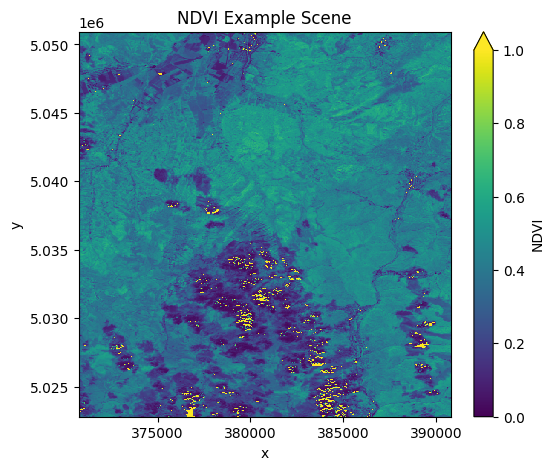

In [11]:
example_scene = ndvi_masked.isel(time=0)
example_small = example_scene.coarsen(y=4, x=4, boundary="trim").mean()

plt.figure(figsize=(6, 5))
example_small.compute().plot.imshow(vmin=0, vmax=1, cmap="viridis")
plt.title("NDVI Example Scene")
plt.show()

In [19]:
#median NDVI per month
t = pd.to_datetime(ndvi_masked.time.values).astype("datetime64[ns]")
ndvi_masked = ndvi_masked.assign_coords(time=t)

ndvi_monthly = ndvi_masked.groupby("time.month").median("time")
ndvi_monthly.name = "NDVI_monthly_median"

ndvi_monthly

<xarray.DataArray 'NDVI_monthly_median' (month: 2, y: 2814, x: 2007)> Size: 90MB
dask.array<stack, shape=(2, 2814, 2007), dtype=float64, chunksize=(1, 2814, 2007), chunktype=numpy.ndarray>
Coordinates:
  * month        (month) int64 16B 8 9
  * y            (y) float64 23kB 5.051e+06 5.051e+06 ... 5.023e+06 5.023e+06
  * x            (x) float64 16kB 3.708e+05 3.708e+05 ... 3.908e+05 3.908e+05
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

Example month: 8


2025-12-10 20:08:39,639 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 754.73 MiB -- Worker memory limit: 0.93 GiB
2025-12-10 20:08:39,934 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 764.73 MiB -- Worker memory limit: 0.93 GiB
2025-12-10 20:08:45,605 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 765.14 MiB -- Worker memory limit: 0.93 GiB
2025-12-10 20:08:45,645 - distributed.worker.memory - WARNING - Worker is at 67% memory usage. Resuming worker. Process memory: 642.29 MiB -- Worker memory limit: 0.93 GiB
2025-12-10 20:08:45,887 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 7

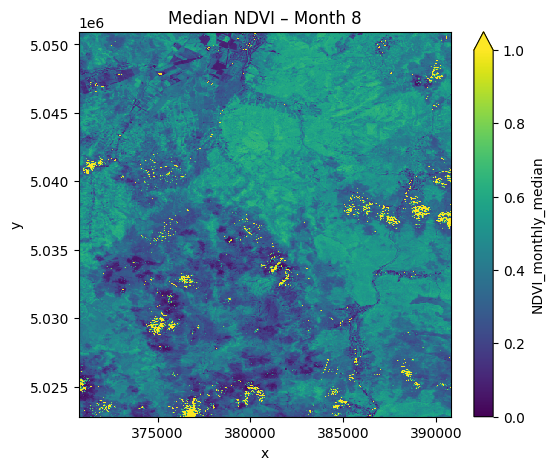

In [20]:
example_month = int(ndvi_monthly.month.values[0])
print("Example month:", example_month)

monthly_small = ndvi_monthly.sel(month=example_month).coarsen(
    y=4, x=4, boundary="trim"
).mean()

plt.figure(figsize=(6, 5))
monthly_small.compute().plot.imshow(vmin=0, vmax=1, cmap="viridis")
plt.title(f"Median NDVI – Month {example_month}")
plt.show()

In [22]:
#single-threaded execution
t0 = time.time()
with dask.config.set(scheduler="single-threaded"):
    _ = ndvi_monthly.mean().compute()
t1 = time.time()

print(f"Single-threaded mean NDVI monthly compute time: {t1 - t0:.2f} s")

Single-threaded mean NDVI monthly compute time: 2.22 s


In [26]:
#Dask distributed - compute mean NDVI per month as scalars
t0 = time.time()

monthly_means = []
for m in ndvi_monthly["month"].values:
    print(f"Computing mean NDVI for month {int(m)}...")
    mean_m = ndvi_monthly.sel(month=m).mean(dim=("y", "x"), skipna=True).compute()
    monthly_means.append(float(mean_m))

t1 = time.time()

print("\nMean NDVI per month:", monthly_means)
print(f"Dask distributed monthly mean compute time: {t1 - t0:.2f} s")

Computing mean NDVI for month 8...


2025-12-10 20:13:51,367 - distributed.worker.memory - WARNING - Worker is at 91% memory usage. Pausing worker.  Process memory: 875.28 MiB -- Worker memory limit: 0.93 GiB


Computing mean NDVI for month 9...


2025-12-10 20:13:51,618 - distributed.worker.memory - WARNING - Worker is at 19% memory usage. Resuming worker. Process memory: 182.09 MiB -- Worker memory limit: 0.93 GiB



Mean NDVI per month: [0.4245373370834741, 0.42637617519363086]
Dask distributed monthly mean compute time: 5.28 s


In [27]:
#experiment with chunking
ndvi_monthly_rechunk = ndvi_monthly.chunk({"y": 256, "x": 256})

t0 = time.time()
monthly_means = []

for m in ndvi_monthly_rechunk["month"].values:
    mean_m = (
        ndvi_monthly_rechunk.sel(month=m)
        .mean(dim=("y", "x"), skipna=True)
        .compute()
    )
    monthly_means.append(float(mean_m))

t1 = time.time()

print("Means per month:", monthly_means)
print(f"Compute time: {t1 - t0:.2f} s")

2025-12-10 20:14:41,246 - distributed.worker.memory - WARNING - Worker is at 85% memory usage. Pausing worker.  Process memory: 818.04 MiB -- Worker memory limit: 0.93 GiB
2025-12-10 20:14:41,390 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 0.90 GiB -- Worker memory limit: 0.93 GiB
2025-12-10 20:14:41,570 - distributed.worker.memory - WARNING - Worker is at 24% memory usage. Resuming worker. Process memory: 236.85 MiB -- Worker memory limit: 0.93 GiB


Means per month: [0.4245373370834741, 0.42637617519363086]
Compute time: 6.48 s


In [28]:
#export
os.makedirs("ndvi_monthly_geotiff", exist_ok=True)

#propagate CRS/transform from red_cube to ndvi_monthly
ndvi_monthly = ndvi_monthly.rio.write_crs(red_cube.rio.crs, inplace=False)
ndvi_monthly = ndvi_monthly.rio.write_transform(red_cube.rio.transform(), inplace=False)

for month_val in ndvi_monthly.month.values:
    da = ndvi_monthly.sel(month=int(month_val))
    
    #ensure 2D DataArray with y,x
    da = da.squeeze(drop=True)
    
    out_path = os.path.join("ndvi_monthly_geotiff", f"ndvi_median_month_{int(month_val):02d}.tif")
    
    da.rio.write_nodata(np.nan, inplace=True)
    
    da.rio.to_raster(
        out_path,
        driver="GTiff",
        tiled=True,
        BLOCKXSIZE=256,
        BLOCKYSIZE=256,
        COMPRESS="DEFLATE",
    )
    
    print("Saved monthly NDVI GeoTIFF:", out_path)

2025-12-10 20:14:50,528 - distributed.worker.memory - WARNING - Worker is at 86% memory usage. Pausing worker.  Process memory: 824.20 MiB -- Worker memory limit: 0.93 GiB
2025-12-10 20:14:50,645 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 0.91 GiB -- Worker memory limit: 0.93 GiB
2025-12-10 20:14:52,705 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 768.80 MiB -- Worker memory limit: 0.93 GiB
2025-12-10 20:14:52,737 - distributed.worker.memory - WARNING - Worker is at 63% memory usage. Resuming worker. Process memory: 610.11 MiB -- Worker memory limit: 0.93 GiB


Saved monthly NDVI GeoTIFF: ndvi_monthly_geotiff/ndvi_median_month_08.tif


2025-12-10 20:14:57,262 - distributed.worker.memory - WARNING - Worker is at 84% memory usage. Pausing worker.  Process memory: 801.95 MiB -- Worker memory limit: 0.93 GiB
2025-12-10 20:15:00,441 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 768.76 MiB -- Worker memory limit: 0.93 GiB
2025-12-10 20:15:00,450 - distributed.worker.memory - WARNING - Worker is at 36% memory usage. Resuming worker. Process memory: 348.66 MiB -- Worker memory limit: 0.93 GiB


Saved monthly NDVI GeoTIFF: ndvi_monthly_geotiff/ndvi_median_month_09.tif


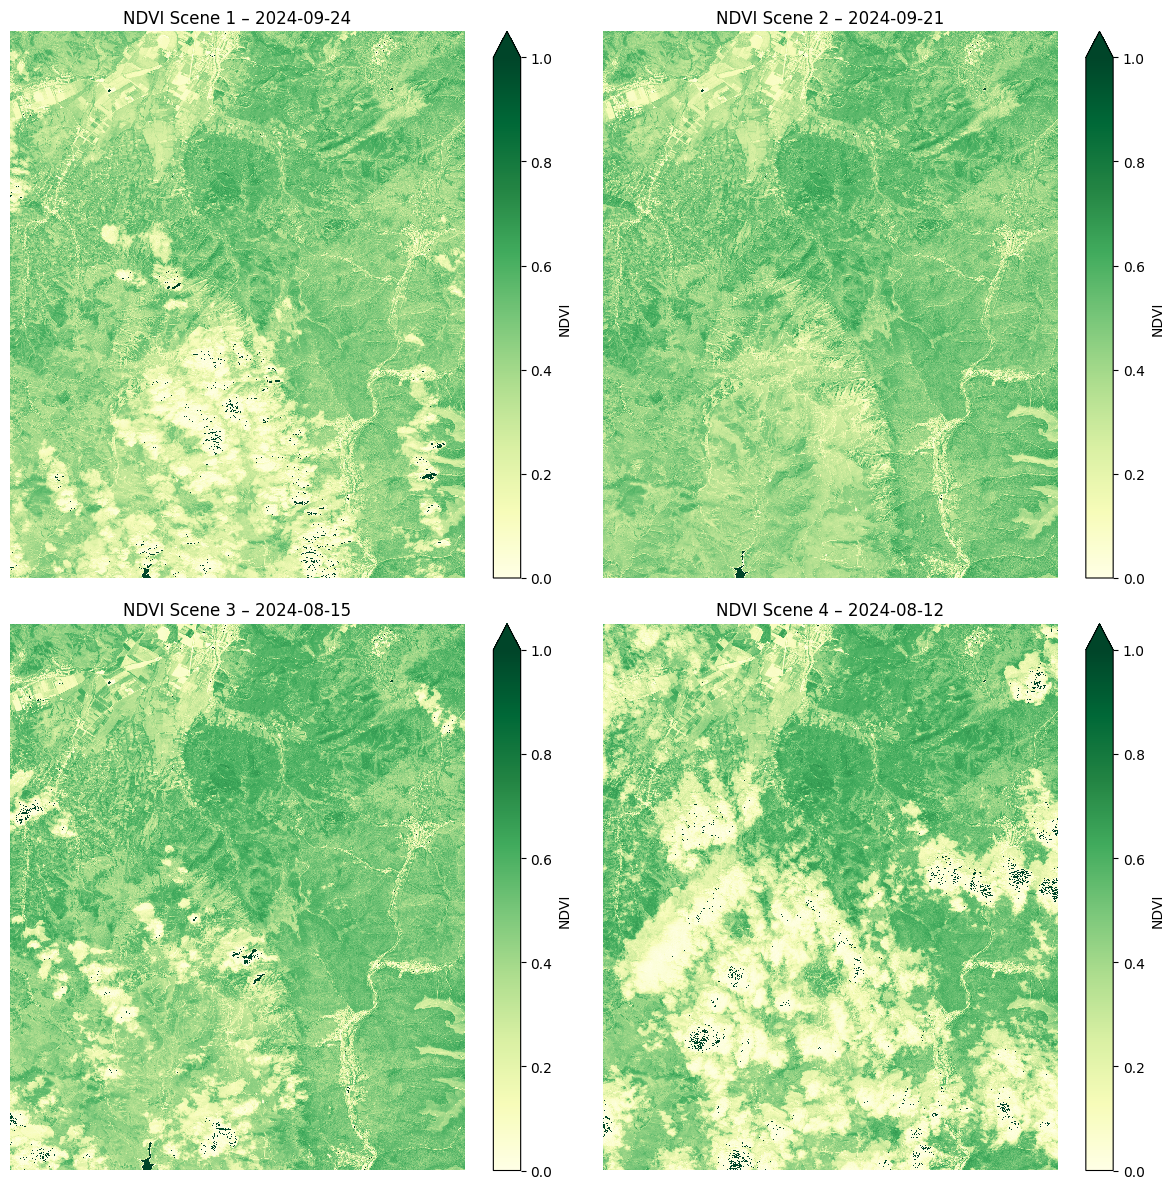

In [29]:
import math

n = ndvi_masked.time.size
cols = 2
rows = math.ceil(n / cols)

plt.figure(figsize=(12, 6*rows))

for i in range(n):
    plt.subplot(rows, cols, i+1)
    ndvi_masked.isel(time=i).plot.imshow(cmap="YlGn", vmin=0, vmax=1)
    date = str(ndvi_masked.time.values[i])[:10]
    plt.title(f"NDVI Scene {i+1} – {date}")
    plt.axis("off")

plt.tight_layout()
plt.show()